# DICE SM Analysis 

## Setup & Initialisation of levers and uncertainties 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import itertools

import os 
os.chdir(os.getcwd())
import sys
# insert at 1, 0 is the script path (or '' in REPL)
pydice_folder = os.path.dirname(os.getcwd())+"\\1_Model"
sys.path.insert(1, pydice_folder)


from changefont import change_fontsize

from specify import specify_levers
from scipy.stats import norm, lognorm, cauchy

from ema_workbench import (save_results, load_results)

from ema_workbench.em_framework.evaluators import perform_experiments, LHS, SOBOL, MORRIS
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring
# from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION

from ema_workbench.util import ema_logging
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)

from PyDICE_V4 import PyDICE

C:\Users\Shajee\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)

In [3]:
model = PyDICE()
dice_sm = Model('dicesmEMA', function = model)

## Exploration

In [4]:
dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                         IntegerParameter('t2xco2_dist',0,2),
                         IntegerParameter('fdamage',0,2),
                         RealParameter('tfp_gr',  0.07, 0.09),
                         RealParameter('sigma_gr', -0.012, -0.008),
                         RealParameter('pop_gr', 0.1, 0.15),
                         RealParameter('fosslim',  4000.0, 13649),
                         IntegerParameter('cback', 100, 600)]

dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                  RealParameter('irstp',  0.001, 0.015),
                  IntegerParameter('periodfullpart', 10, 58),
                  IntegerParameter('miu_period', 10, 58)]

dice_sm.outcomes = [ScalarOutcome('Atmospheric Temperature 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Damages 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Utility 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Total Output 2010', ScalarOutcome.INFO),
                    ScalarOutcome('Atmospheric Temperature 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2050', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2050', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2100', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2100', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2150', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2150', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2200', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2200', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Atmospheric Temperature 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Damages 2300', ScalarOutcome.MINIMIZE),
                    ScalarOutcome('Utility 2300', ScalarOutcome.MAXIMIZE),
                    ScalarOutcome('Total Output 2300', ScalarOutcome.MAXIMIZE)]

In [5]:
n_scenarios=540000
nord_optimal_policy = Policy('nord_optimal_policy', **specify_levers(np.mean(dice_opt.iloc[129]),0.015,0,29))

In [6]:
# start = time.time()
# with MultiprocessingEvaluator(dice_sm) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=nord_optimal_policy)
# end = time.time()
#
# print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

In [7]:
file_name = 'exploration_V4_' + str(n_scenarios) + 'scen_' + 'nordhaus_optimal_policy_' + str(4) + 'obj' + '.tar.gz'
# save_results(results, file_name)
results = load_results(file_name)

[MainProcess/INFO] results loaded succesfully from C:\Users\Shajee\Documents\GitHub\PyDICE\3_Nordhaus_Optimal_Policy_Exploration\exploration_V4_540000scen_nordhaus_optimal_policy_4obj.tar.gz


In [20]:
experiments, outcomes = results

In [21]:
clr_palette = ([sns.cubehelix_palette(8)[6],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[10]])

### Pairplots

#### Effect of distributions on the output

In [26]:
out_DF = pd.DataFrame(outcomes)
t2xco2_dist = experiments['t2xco2_dist']
out_DF['ECS Distribution'] = t2xco2_dist
out_DF['ECS Distribution'] = out_DF['ECS Distribution'].apply(lambda x: 'Normal' if x==0 else ('Log-Normal' if x==1 else 'Cauchy'))

In [27]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=1)

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


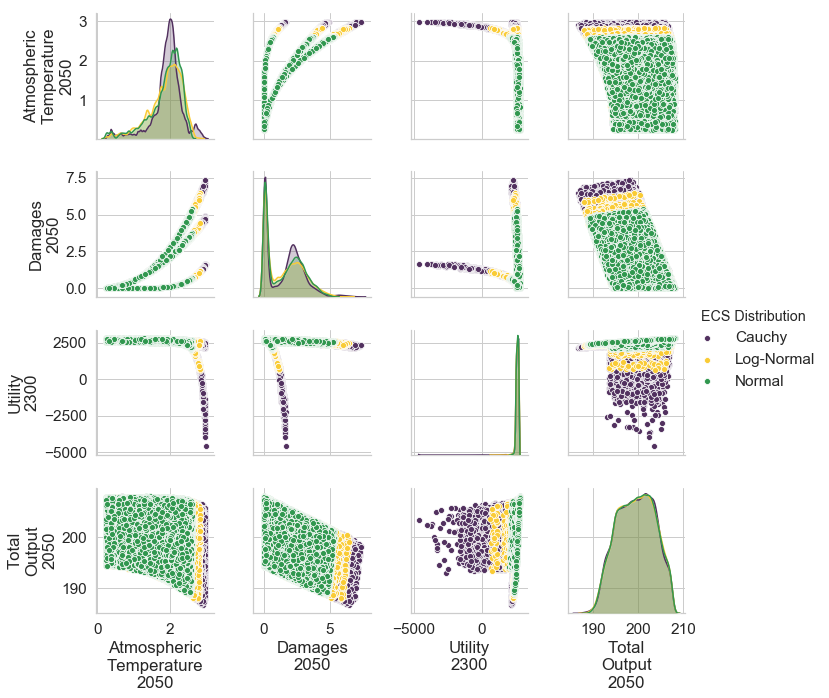

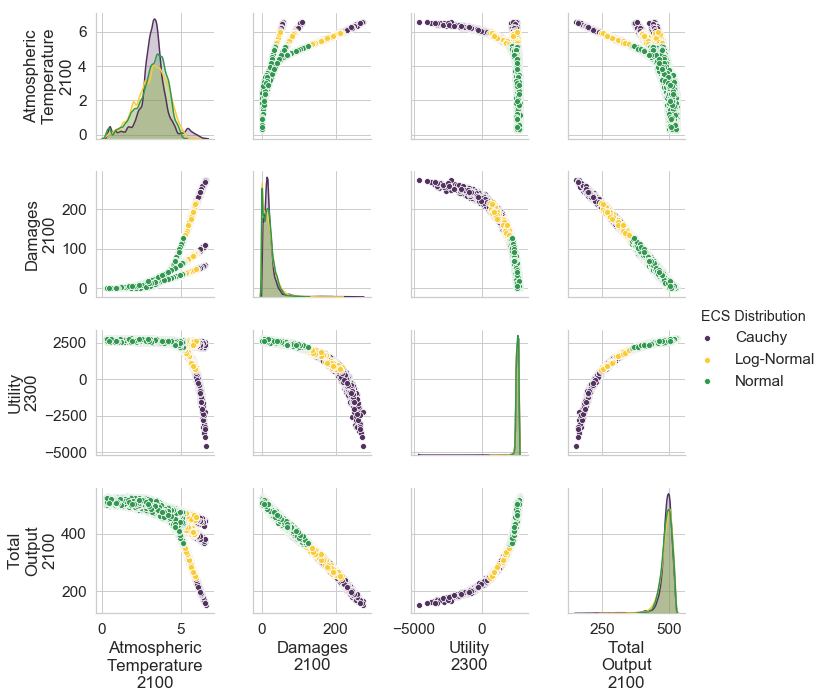

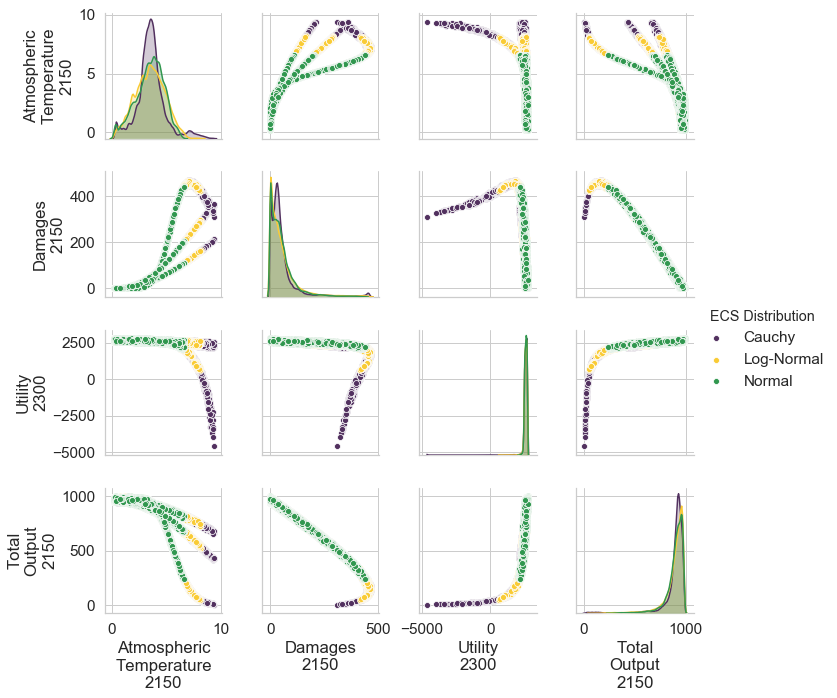

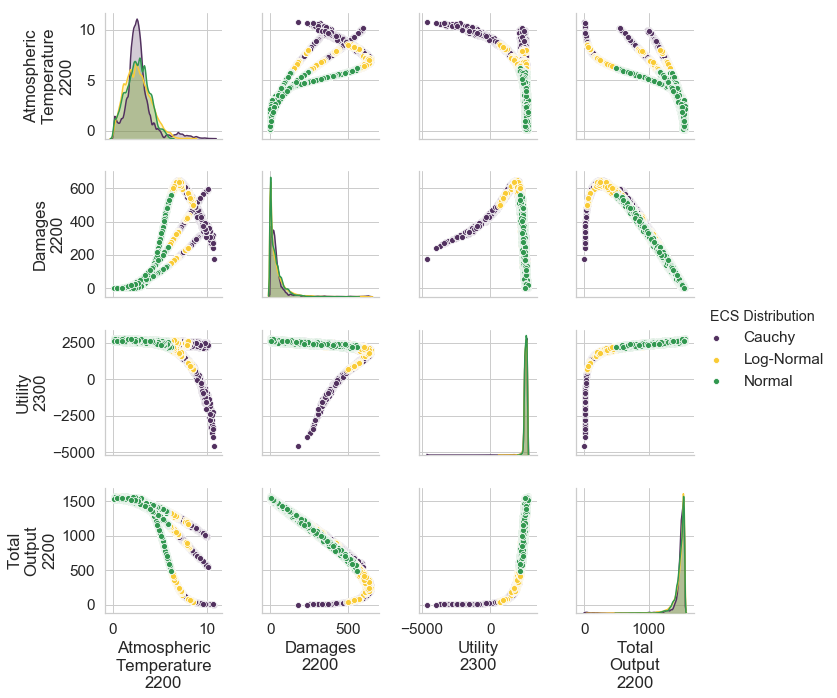

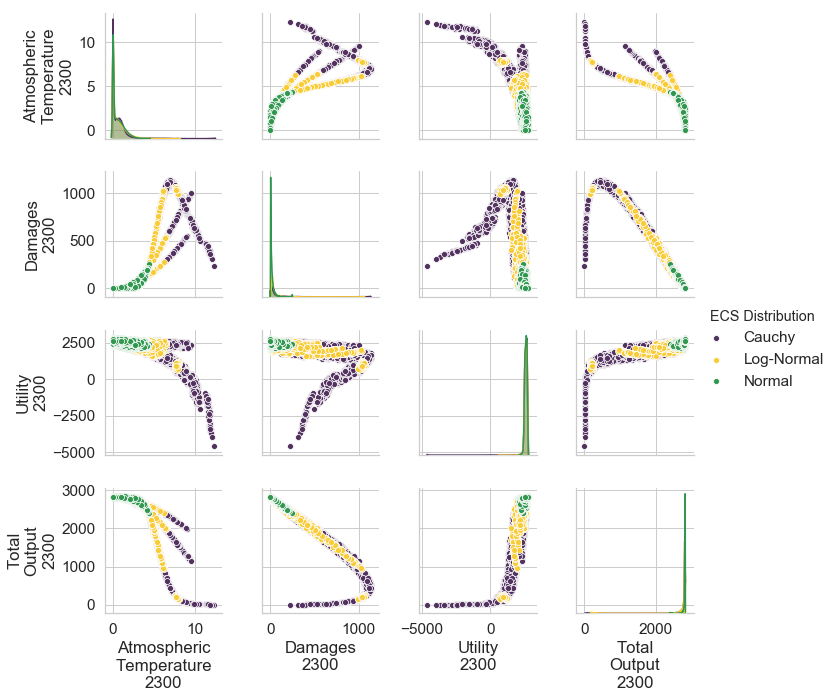

In [28]:
sns.set(style = "whitegrid", font_scale=1.4)
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    pplst_col = ppDF.columns.to_list()
    for i in range(len(pplst_col)-1):
        pplst_col[i] = pplst_col[i].replace(" ", "\n")
    ppDF.columns = pplst_col
    
    
    variable_name = list(list(outcomes.keys())[i] for i in namelist)
    for i in range(len(variable_name)):
        variable_name[i] = variable_name[i].replace(" ", "\n")
    
    
    sns_plot = sns.pairplot(ppDF, hue='ECS Distribution', palette=clr_palette,
                            vars=variable_name)
    #plt.tight_layout()
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_dist_nordhaus_opt_policy_util2300'+'_V4.png')

#### Effect of damage function on the output

In [29]:
out_DF = pd.DataFrame(outcomes)
fdamage = experiments['fdamage']
out_DF['Damage Function'] = fdamage # include damage column into the model output model
out_DF['Damage Function'] = out_DF['Damage Function'].apply(lambda x: 'Nordhaus(2013)' if x==0 else ('Newbold(2009)' if x==1 else 'Weitzman(2010)'))

In [35]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=False)

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


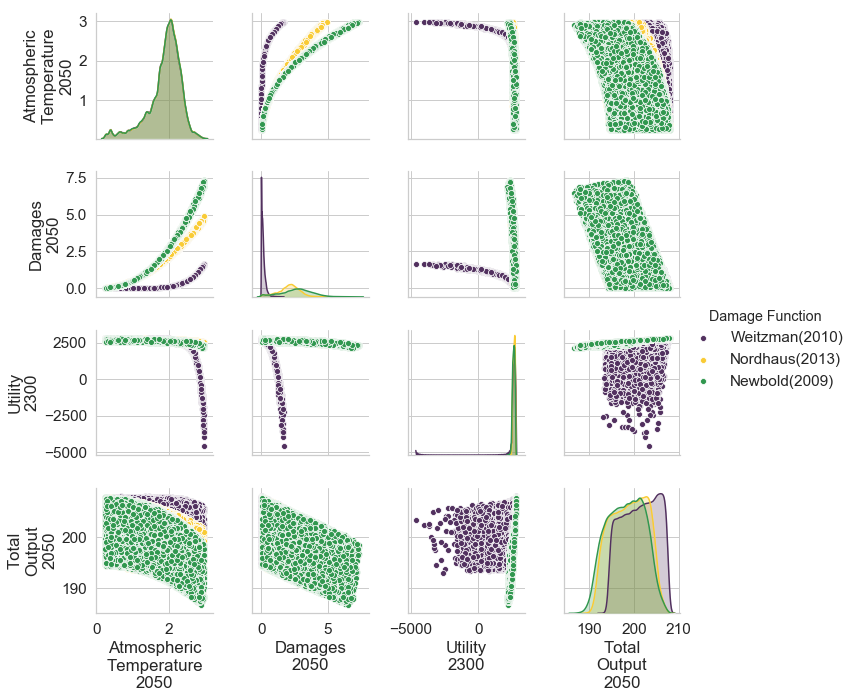

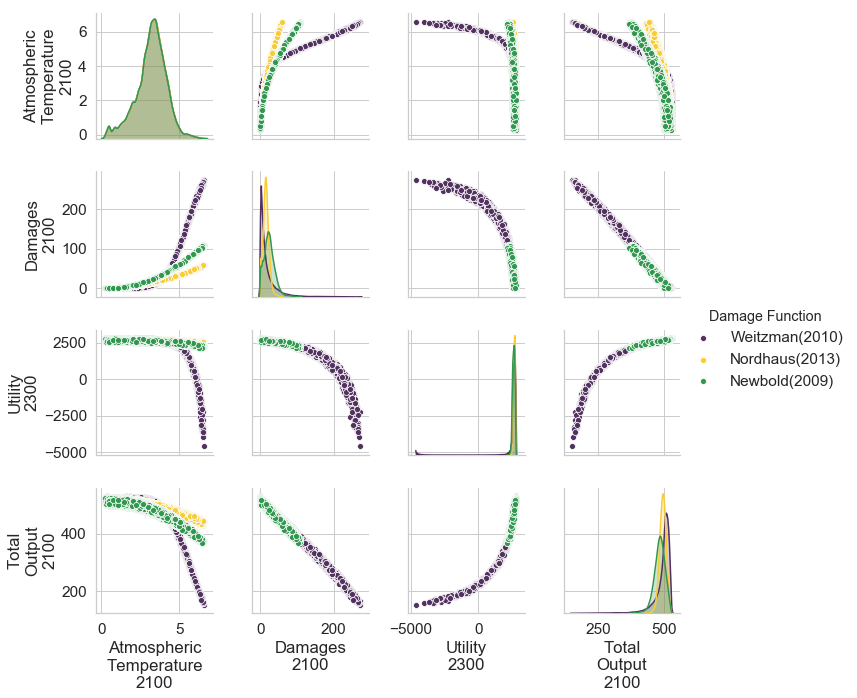

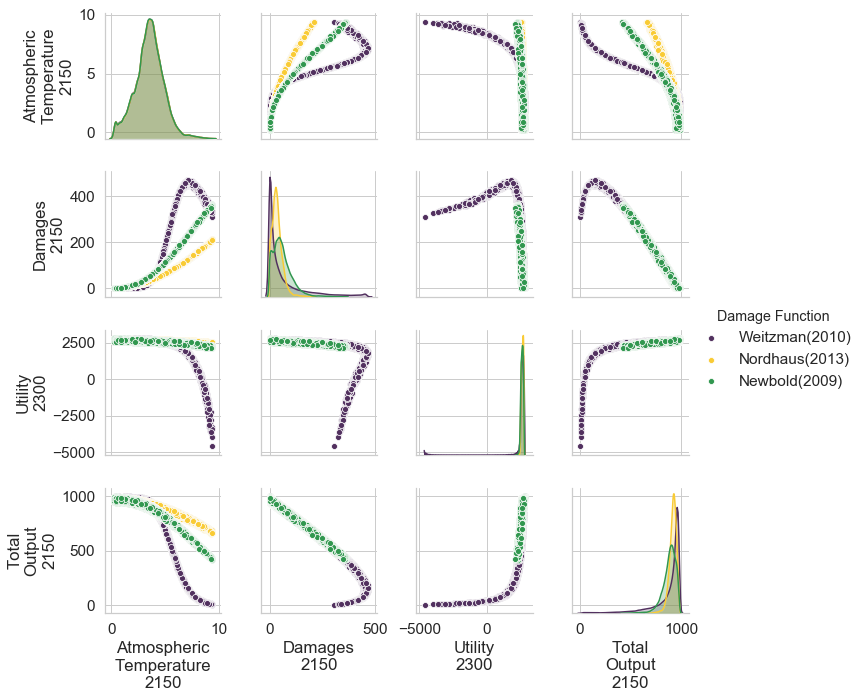

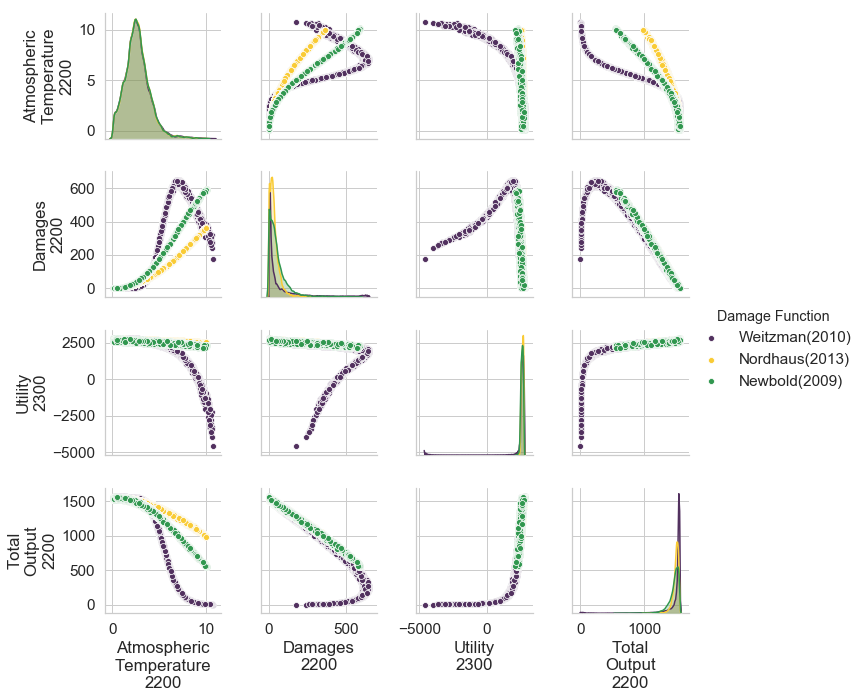

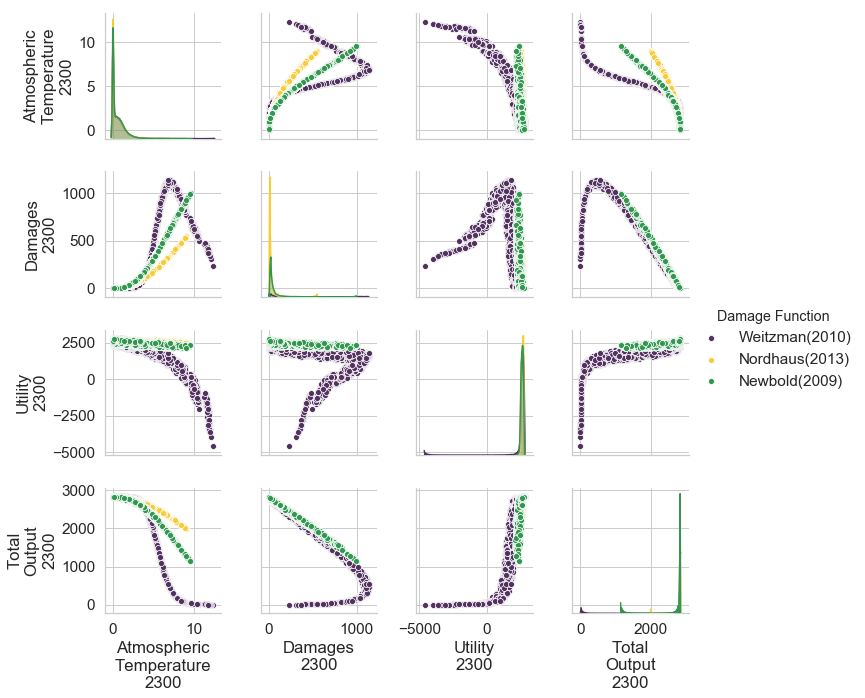

In [37]:
sns.set(style = "whitegrid", font_scale=1.4)
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    pplst_col = ppDF.columns.to_list()
    for i in range(len(pplst_col)-1):
        pplst_col[i] = pplst_col[i].replace(" ", "\n")
    ppDF.columns = pplst_col
    
    variable_name = list(list(outcomes.keys())[i] for i in namelist)
    for i in range(len(variable_name)):
        variable_name[i] = variable_name[i].replace(" ", "\n")
    
    sns_plot = sns.pairplot(ppDF, hue='Damage Function', palette=clr_palette, vars=variable_name)
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_fdamage_nordhaus_opt_policy_util2300'+'_V4.png')

#### Effect of damage function in combination with ecs distributions

In [38]:
out_DF = pd.DataFrame(outcomes)
out_DF['Damage\nFunction'] = fdamage
out_DF['ECS\nDistributon'] = t2xco2_dist
out_DF['ECS\nDistributon'] = out_DF['ECS\nDistributon'].apply(lambda x: 'Normal' if x==0 else ('Log-Normal' if x==1 else 'Cauchy'))
out_DF['Damage\nFunction'] = out_DF['Damage\nFunction'].apply(lambda x: ' + Nordhaus' if x==0 else (' + Newbold' if x==1 else ' + Weitzman'))
out_DF['ECS Distributon + Damage Function'] = out_DF['ECS\nDistributon'] + out_DF['Damage\nFunction']
out_DF = out_DF.drop(out_DF.columns[[-2, -3]], axis=1)

In [39]:
out_DF = out_DF.sort_values([out_DF.columns[-1]], ascending=1)

In [40]:
sns.set(style = "whitegrid", palette=sns.set_palette("tab10"), font_scale=1.4)

C:\Users\Shajee\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


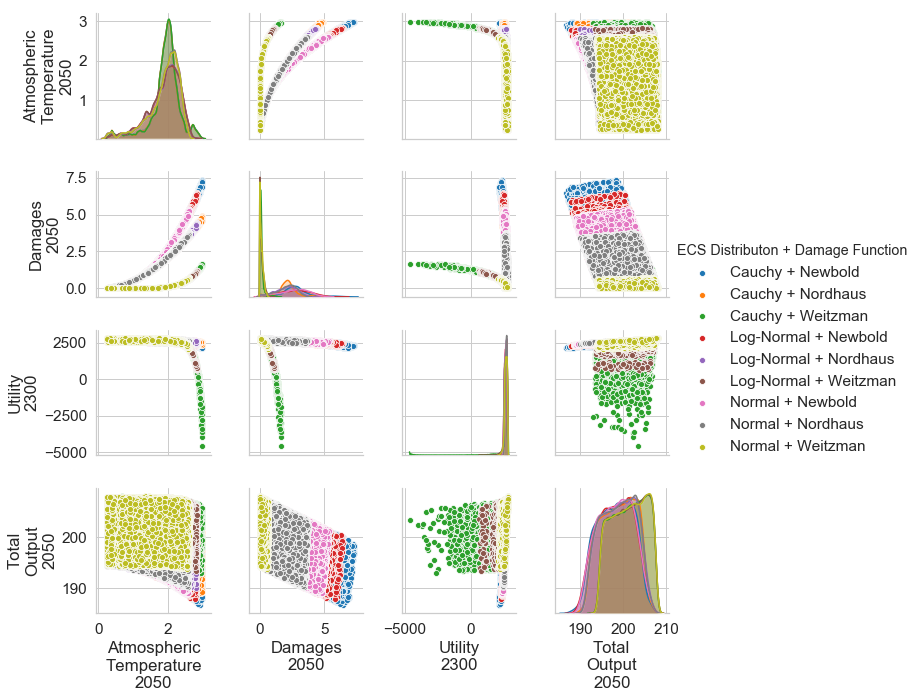

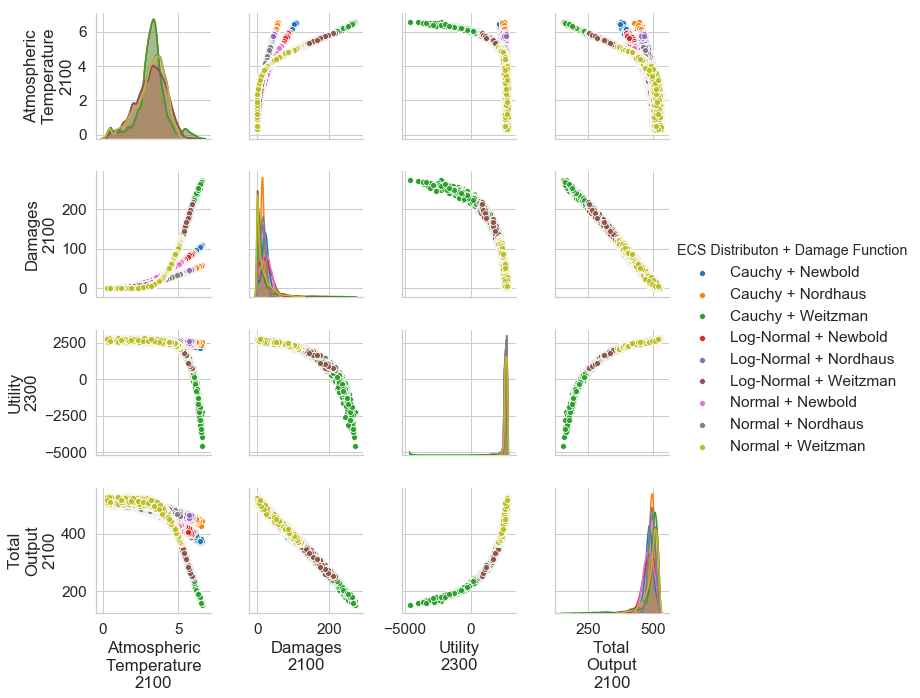

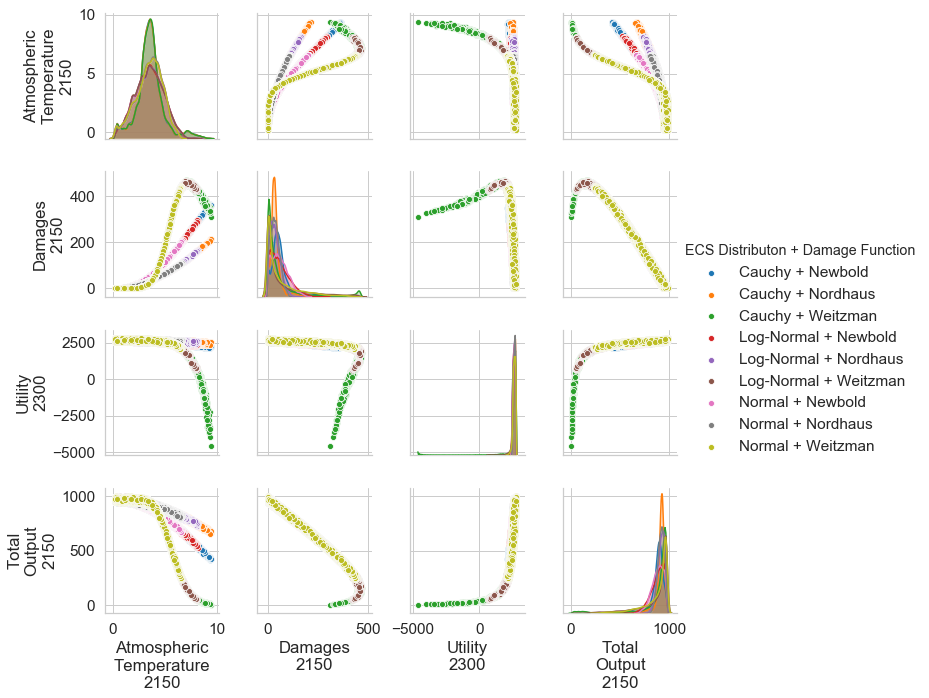

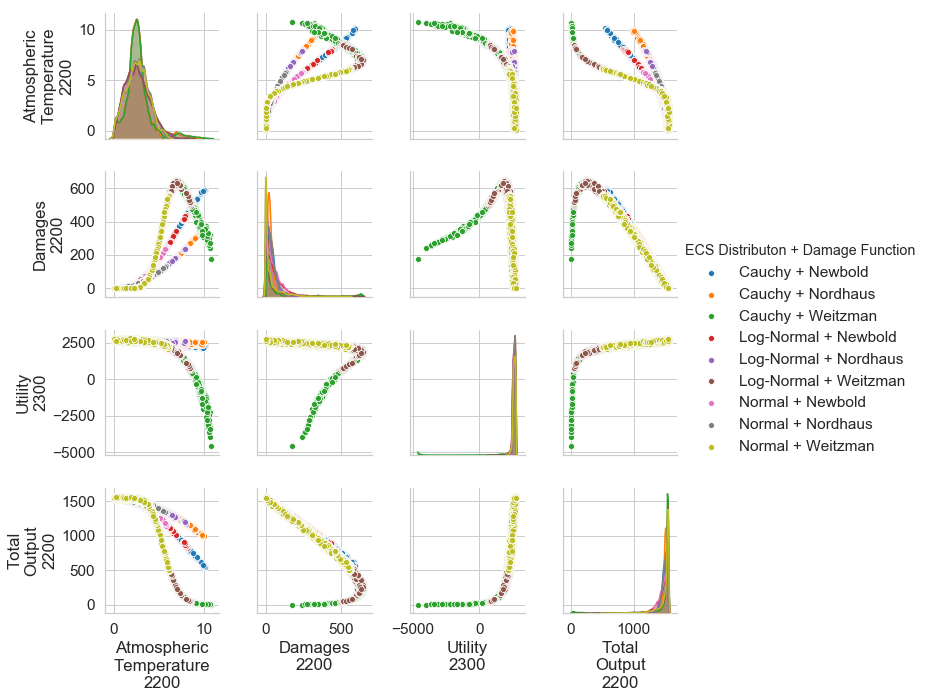

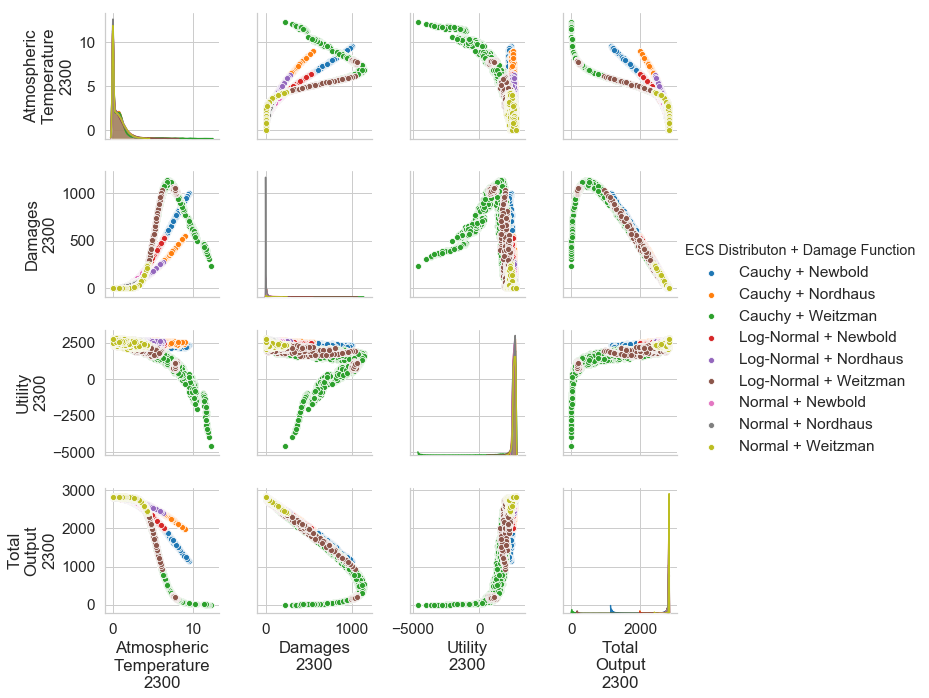

In [43]:
for _ in range(1,6):
    colmlst = list(range(0+_*4,4+_*4))
    namelist = colmlst[:]
    colmlst[2] = -3
    namelist[2] = -2
    
    ppDF = out_DF.iloc[:,colmlst+[-1]]
    pplst_col = ppDF.columns.to_list()
    for i in range(len(pplst_col)-1):
        pplst_col[i] = pplst_col[i].replace(" ", "\n")
    ppDF.columns = pplst_col
    
    variable_name = list(list(outcomes.keys())[i] for i in namelist)
    for i in range(len(variable_name)):
        variable_name[i] = variable_name[i].replace(" ", "\n")
    
    
    sns_plot = sns.pairplot(ppDF, hue='ECS Distributon + Damage Function', vars=variable_name)
    plt.show()
    sns_plot.savefig('pairplot_'+str(list(outcomes.keys())[_*4][-4:])+'_fdamage+dist_nordhaus_opt_policy_util2300'+'_V4.png')

## Statistical Analysis

In [21]:
from scipy.stats import norm, lognorm, cauchy

In [22]:
outDF = pd.DataFrame(outcomes)
expDF = experiments

resDF = pd.concat([expDF,outDF], axis=1, join_axes=[expDF.index])

resDF['t2xco2_dist'] = resDF['t2xco2_dist'].apply(lambda x: 'Normal' if x==0 else ('Log-normal' if x==1 else 'Cauchy'))
resDF['fdamage'] = resDF['fdamage'].apply(lambda x: 'Nordhaus' if x==0 else ('Newbold & Daigneault' if x==1 else 'Weitzman'))

#resDF = resDF.drop(resDF[["fdamage", 't2xco2_dist']], axis=1)

### Distributions

#### DISTPLOT

In [23]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF["t2xco2_dist"]))):
#             sns.distplot(resDF[resDF["t2xco2_dist"] == np.unique(resDF["t2xco2_dist"])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF["t2xco2_dist"])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [24]:
# fig.savefig('distplot_'+'dist'+'_nordhaus_opt_policy'+'_V3.png')

#### BOXPLOT

In [25]:
clr_palette = ([sns.cubehelix_palette(10)[5],sns.color_palette("inferno", 15)[-2],sns.color_palette("YlGn", 15)[9]])

In [43]:
for k in range(int(len(outDF.columns.values[4:])/5)):
    box_damageDF = pd.concat([resDF.iloc[:,19+k::4],resDF['t2xco2_dist']], axis=1, join_axes = [resDF.index])
    box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","t2xco2_dist"]    
    box_damageDF = box_damageDF.melt(id_vars=['t2xco2_dist'], var_name="Year" , value_name=outDF.columns.values[k][:-5])
    box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=True)
    #plt.figure(figsize=(30, 15))
    distbox = sns.boxenplot(x="Year", y=outDF.columns.values[k][:-5], data=box_damageDF, hue="t2xco2_dist", palette=clr_palette, ax=axes[i,j])
    #distbox.axes.set_xticklabels(labels=box_damageDF["variable"].unique(), rotation=45)
    distbox.legend().remove()
    distbox.axes.grid(alpha=0.5)
    #distbox.figure.savefig('boxenplot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png', bbox_inches = "tight")

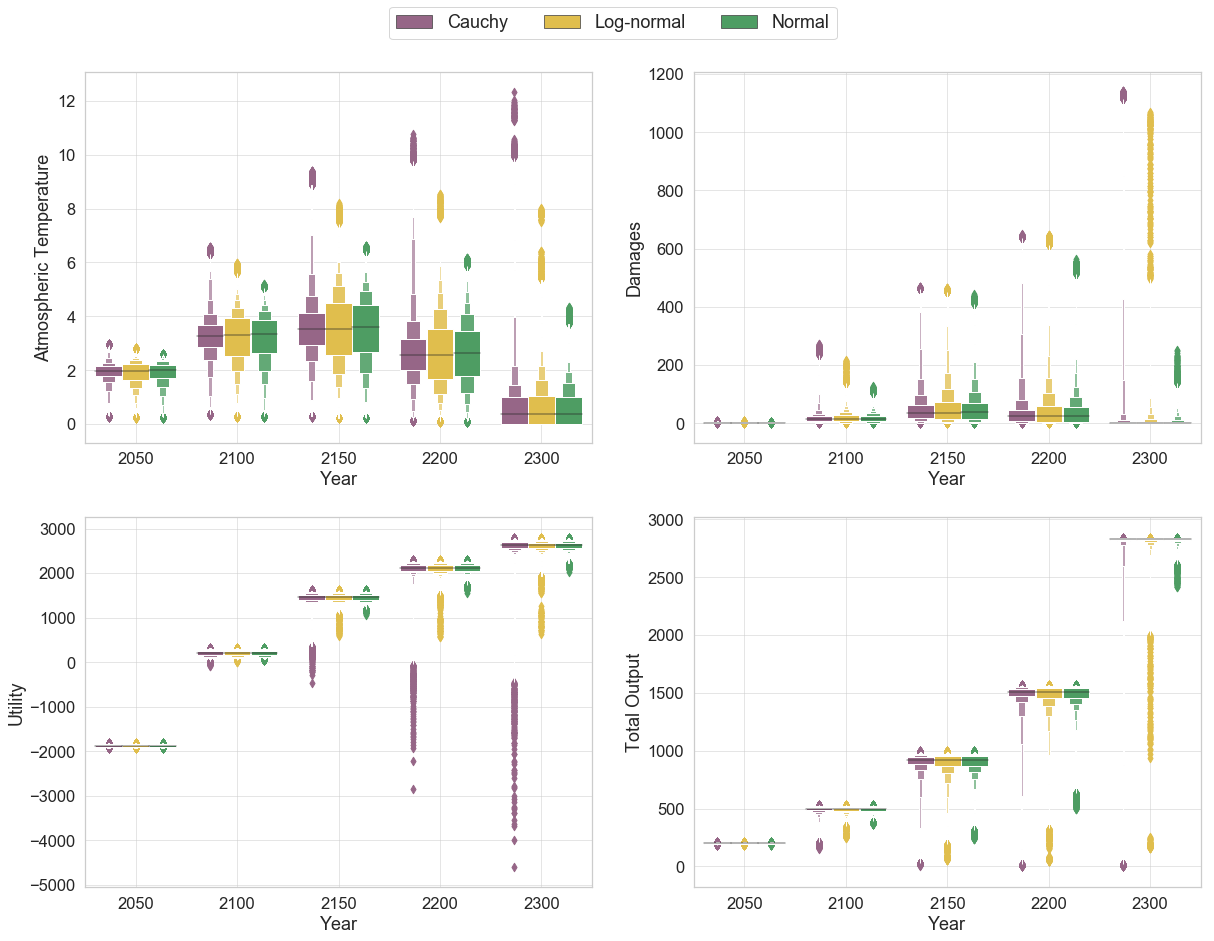

In [105]:
sns.set(style = "whitegrid", font_scale=1.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for i in range (2):
    for j in range (2):
        # axes[i,j].set_title(title_list[2*i+j])
        # sns.lineplot(data = pd.DataFrame([dice_om_plot[2*i+j], dice_sm_plot[2*i+j]], 
        #                                 index = ["DICE_OPT", "DICE_SM"], columns=list(range(2010,2310,5))).T, 
        #             linewidth = 2.5, palette=clr_palette, ax=axes[i,j])
        box_damageDF = pd.concat([resDF.iloc[:,19+(2*i+j)::4],resDF['t2xco2_dist']], axis=1, join_axes = [resDF.index])
        box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","t2xco2_dist"]    
        box_damageDF = box_damageDF.melt(id_vars=['t2xco2_dist'], var_name="Year" , value_name=outDF.columns.values[(2*i+j)][:-5])
        box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=True)
        #plt.figure(figsize=(30, 15))
        distbox = sns.boxenplot(x="Year", y=outDF.columns.values[(2*i+j)][:-5], data=box_damageDF, hue="t2xco2_dist", palette=clr_palette, ax=axes[i,j])
        #distbox.axes.set_xticklabels(labels=box_damageDF["variable"].unique(), rotation=45)
        distbox.axes.grid(alpha=0.5)
        distbox.legend().remove()
handles, labels = distbox.get_legend_handles_labels()
#handles, labels = fig.get_legend_handles_labels()
distbox.legend(handles[:], labels, bbox_to_anchor=[0.3, 2.4], ncol = 3, fontsize=18)
fig.savefig('boxenplot_dist_nordhaus_opt_policy_V4.png', bbox_inches = "tight")

In [106]:
# box_damageDF = pd.concat([resDF.iloc[:,37],resDF['t2xco2_dist']], axis=1, join_axes = [resDF.index])
# #     box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","t2xco2_dist"]    
# #     box_damageDF = box_damageDF.melt(id_vars=['t2xco2_dist'], var_name="Year" , value_name=outDF.columns.values[i][:-5])
# #     box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=True)
# #     plt.figure(figsize=(30, 15))
# #     distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="t2xco2_dist", palette=clr_palette)
# #     distbox.legend(fontsize=28, loc = "upper left")
# #     #distbox.axes.set_xticklabels(labels=box_damageDF["variable"].unique(), rotation=45)
# #     distbox.axes.grid(alpha=0.5)
# #     distbox.figure.savefig('boxenplot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png')

In [107]:
# sns.set(style = "whitegrid", font_scale=2.6)
# plt.figure(figsize=(30, 15))
# fig = sns.boxenplot(x=box_damageDF["Utility 2300"], y=box_damageDF["t2xco2_dist"] ,data=box_damageDF, hue="t2xco2_dist", palette=clr_palette, width=1.5)
# fig.tick_params(axis = "y",  which='major', pad=50)
# fig.set_ylabel('')
# fig.set_yticklabels("")
# plt.legend(fontsize=28)
# plt.show()

#### Describe the statistical results of the model outcome

In [108]:
norm_desc_DF = resDF[resDF["t2xco2_dist"] == "Normal"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_norm = []
for _ in norm_desc_DF.columns.values:
    colmn_norm.append(_+' Normal')
norm_desc_DF.columns = colmn_norm


lognorm_desc_DF = resDF[resDF["t2xco2_dist"] == "Log-normal"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_lognorm = []
for _ in lognorm_desc_DF.columns.values:
    colmn_lognorm.append(_+' Lognormal')
lognorm_desc_DF.columns = colmn_lognorm


cauchy_desc_DF = resDF[resDF["t2xco2_dist"] == "Cauchy"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_cauchy = []
for _ in cauchy_desc_DF.columns.values:
    colmn_cauchy.append(_+' Cauchy')
cauchy_desc_DF.columns = colmn_cauchy

In [109]:
dist_describeDF = pd.concat([norm_desc_DF, lognorm_desc_DF, cauchy_desc_DF], axis = 1, join_axes = [norm_desc_DF.index])

In [110]:
dist_describeDF = dist_describeDF.sort_index(axis=1)

In [111]:
dist_describeDF

,Atmospheric Temperature 2050 Cauchy,Atmospheric Temperature 2050 Lognormal,Atmospheric Temperature 2050 Normal,Atmospheric Temperature 2100 Cauchy,Atmospheric Temperature 2100 Lognormal,Atmospheric Temperature 2100 Normal,Atmospheric Temperature 2150 Cauchy,Atmospheric Temperature 2150 Lognormal,Atmospheric Temperature 2150 Normal,Atmospheric Temperature 2200 Cauchy,...,Utility 2100 Normal,Utility 2150 Cauchy,Utility 2150 Lognormal,Utility 2150 Normal,Utility 2200 Cauchy,Utility 2200 Lognormal,Utility 2200 Normal,Utility 2300 Cauchy,Utility 2300 Lognormal,Utility 2300 Normal
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,...,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,1.929746,1.893237,1.892596,3.256928,3.189468,3.182666,3.598418,3.517696,3.499056,2.736513,...,204.418273,1447.124912,1451.454967,1454.199300,2103.196801,2112.632801,2117.046965,2598.820831,2612.430887,2617.409228
std,0.418041,0.456793,0.455004,0.936537,1.002137,0.964284,1.325596,1.363066,1.277725,1.407897,...,61.930234,110.454545,82.839192,77.731051,173.595258,96.891927,85.023878,221.860861,101.685641,86.547989
min,0.274103,0.241125,0.238191,0.341266,0.267347,0.268872,0.276743,0.211466,0.210656,0.103431,...,46.568267,-468.047875,587.570183,1057.743767,-2839.775938,554.788818,1555.613856,-4605.042731,621.406167,2026.531552
1%,0.392460,0.466666,0.358112,0.514679,0.600795,0.459540,0.418481,0.498464,0.374372,0.221702,...,81.920063,1025.603006,1247.598571,1281.137907,1372.145873,1833.131501,1908.117408,1741.832531,2316.043595,2401.320377
5%,1.106143,0.989315,0.946809,1.534403,1.366683,1.287279,1.399699,1.225643,1.143900,0.782237,...,103.584191,1319.600739,1319.839082,1327.258896,1969.825157,1968.335940,1979.910494,2466.202102,2465.511539,2478.242161
10%,1.489419,1.268709,1.274472,2.212483,1.822312,1.824354,2.154766,1.708570,1.712268,1.332084,...,118.579076,1346.189054,1345.914536,1350.109627,2003.571632,2001.135359,2007.149995,2502.456357,2499.730521,2506.310584
25%,1.798106,1.651324,1.705756,2.851746,2.539183,2.643213,2.950026,2.550227,2.681487,2.003450,...,153.509831,1392.979686,1391.999937,1394.141912,2054.618190,2052.493497,2055.375240,2554.589405,2552.360338,2555.425023
50%,1.983919,1.983207,2.004632,3.285944,3.288685,3.340785,3.542027,3.545312,3.619614,2.560762,...,207.550065,1459.070901,1456.627712,1458.346153,2123.993133,2120.415201,2122.293094,2624.679400,2620.948420,2622.946540
75%,2.138675,2.224587,2.207369,3.689770,3.923385,3.879338,4.130079,4.488012,4.419636,3.151186,...,256.171299,1518.240931,1516.258257,1516.639108,2185.844226,2183.621801,2183.771375,2687.166792,2684.836546,2684.985963


In [112]:
splitDF = np.split(dist_describeDF, [15,30,45], axis=1)

In [113]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [114]:
with pd.ExcelWriter("statistical_description_dist_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])

In [115]:
# fig, ax = plt.subplots()
# resDF["Atmospheric Temperature 2100"].hist(bins=30, ax=ax)
# ax.set_xlim(5, 10)
# ax.set_ylim(0, 8000)

### Damage Functions

In [116]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF["fdamage"]))):
#             sns.distplot(resDF[resDF["fdamage"] == np.unique(resDF["fdamage"])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF["fdamage"])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [117]:
# fig.savefig('distplot_'+'fdamage'+'_nordhaus_opt_policy'+'_V3.png')

In [118]:
# for i in range(int(len(outDF.columns.values[4:])/5)):
#     box_damageDF = pd.concat([resDF.iloc[:,19+i::4],resDF['fdamage']], axis=1, join_axes = [resDF.index])
#     box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage"]    
#     box_damageDF = box_damageDF.melt(id_vars=['fdamage'], var_name="Year" , value_name=outDF.columns.values[i][:-5])
#     box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
#     plt.figure(figsize=(30, 15))
#     distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="fdamage", palette=clr_palette)
#     distbox.legend(fontsize=28, loc = "upper left")
#     distbox.axes.grid(alpha=0.5)
#     distbox.figure.savefig('fdamageplot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png', bbox_inches = "tight")

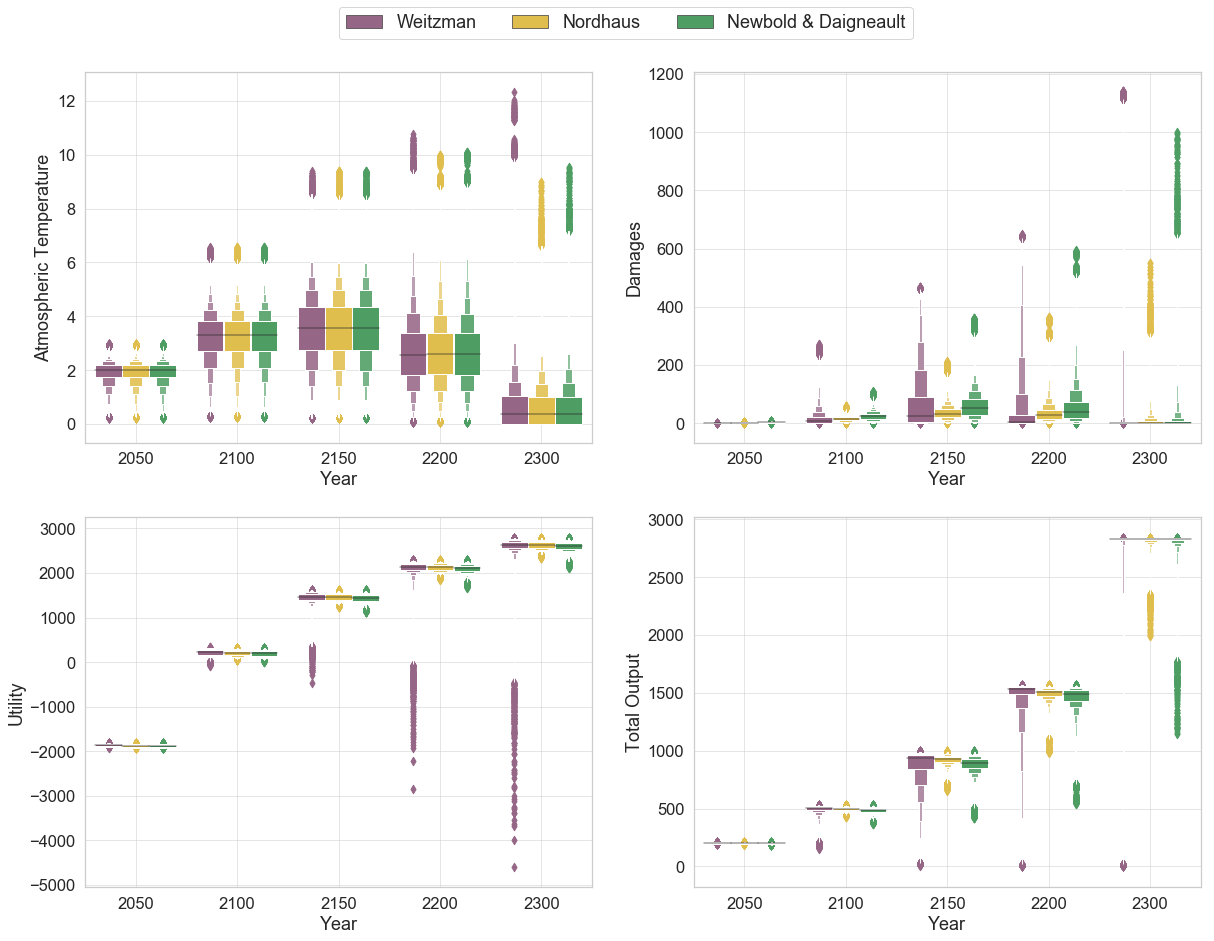

In [132]:
sns.set(style = "whitegrid", font_scale=1.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for i in range (2):
    for j in range (2):
        box_damageDF = pd.concat([resDF.iloc[:,19+(2*i+j)::4],resDF['fdamage']], axis=1, join_axes = [resDF.index])
        box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage"]    
        box_damageDF = box_damageDF.melt(id_vars=['fdamage'], var_name="Year" , value_name=outDF.columns.values[(2*i+j)][:-5])
        box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
        distbox = sns.boxenplot(x="Year", y=outDF.columns.values[(2*i+j)][:-5], data=box_damageDF, hue="fdamage", palette=clr_palette, ax=axes[i,j])
        distbox.axes.grid(alpha=0.5)
        distbox.legend().remove()
handles, labels = distbox.get_legend_handles_labels()
distbox.legend(handles[:], labels, bbox_to_anchor=[0.45, 2.4], ncol = 3, fontsize=18)
fig.savefig('boxenplot_fdamage_nordhaus_opt_policy_V4.png', bbox_inches = "tight")

#### Describe the statistical results of the model outcome

In [133]:
nord_desc_DF = resDF[resDF["fdamage"] == "Nordhaus"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_nord = []
for _ in nord_desc_DF.columns.values:
    colmn_nord.append(_+' Nordhaus')
nord_desc_DF.columns = colmn_nord


new_desc_DF = resDF[resDF["fdamage"] == "Newbold & Daigneault"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_new = []
for _ in new_desc_DF.columns.values:
    colmn_new.append(_+' Newbold')
new_desc_DF.columns = colmn_new


weitz_desc_DF = resDF[resDF["fdamage"] == "Weitzman"].iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
colmn_weitz = []
for _ in weitz_desc_DF.columns.values:
    colmn_weitz.append(_+' Weitzman')
weitz_desc_DF.columns = colmn_weitz

In [134]:
dist_fdamageDF = pd.concat([nord_desc_DF, new_desc_DF, weitz_desc_DF], axis = 1, join_axes = [norm_desc_DF.index])

In [135]:
dist_fdamageDF = dist_fdamageDF.sort_index(axis=1, ascending=True)

In [136]:
dist_fdamageDF

,Atmospheric Temperature 2050 Newbold,Atmospheric Temperature 2050 Nordhaus,Atmospheric Temperature 2050 Weitzman,Atmospheric Temperature 2100 Newbold,Atmospheric Temperature 2100 Nordhaus,Atmospheric Temperature 2100 Weitzman,Atmospheric Temperature 2150 Newbold,Atmospheric Temperature 2150 Nordhaus,Atmospheric Temperature 2150 Weitzman,Atmospheric Temperature 2200 Newbold,...,Utility 2100 Weitzman,Utility 2150 Newbold,Utility 2150 Nordhaus,Utility 2150 Weitzman,Utility 2200 Newbold,Utility 2200 Nordhaus,Utility 2200 Weitzman,Utility 2300 Newbold,Utility 2300 Nordhaus,Utility 2300 Weitzman
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,...,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,1.905339,1.906269,1.903971,3.208250,3.211442,3.209371,3.535783,3.541111,3.538277,2.675616,...,218.525496,1438.097737,1457.652340,1457.029103,2100.047438,2123.288469,2109.540660,2599.763075,2623.774168,2605.123703
std,0.444210,0.443259,0.444463,0.968216,0.966924,0.970673,1.322263,1.321802,1.325805,1.308216,...,61.950673,77.503462,72.322435,116.814891,83.522485,75.498463,184.128819,85.495468,76.352004,231.907612
min,0.238821,0.239045,0.238191,0.268824,0.267547,0.267347,0.210656,0.210846,0.210689,0.077173,...,-89.603076,1114.925392,1229.380565,-468.047875,1670.681689,1849.853191,-2839.775938,2113.086161,2329.659882,-4605.042731
1%,0.390228,0.390383,0.390756,0.507820,0.508129,0.509292,0.413894,0.414118,0.415153,0.213019,...,97.083680,1267.267762,1314.179113,1007.393052,1903.165350,1969.746000,1348.787790,2392.040525,2467.347560,1713.089591
5%,0.991816,0.995290,0.990030,1.371795,1.378647,1.372208,1.229655,1.237471,1.230835,0.683204,...,119.789641,1311.221941,1338.588957,1308.628045,1963.479083,1998.890294,1925.887869,2460.335554,2498.034631,2419.749169
10%,1.317756,1.324466,1.317887,1.907442,1.914472,1.907603,1.803406,1.811545,1.803850,1.071417,...,132.158130,1333.479969,1355.854805,1356.227838,1989.384327,2017.627869,2005.011351,2487.637098,2517.169871,2503.799900
25%,1.732396,1.734594,1.730876,2.702449,2.706596,2.700721,2.756587,2.761765,2.755181,1.837765,...,167.506923,1378.247729,1398.473876,1402.979412,2038.044178,2062.287947,2062.755810,2537.402660,2562.335657,2563.188984
50%,1.989423,1.990376,1.988416,3.300094,3.303382,3.301099,3.560893,3.566179,3.563791,2.582824,...,221.951369,1442.093482,1462.498039,1470.565796,2104.672680,2128.476600,2134.774962,2604.766195,2629.003417,2636.036806
75%,2.192915,2.192185,2.190779,3.832514,3.831741,3.831581,4.346293,4.347170,4.346798,3.392716,...,271.796311,1500.074042,1518.582561,1533.259676,2165.761838,2186.187964,2201.662444,2666.630072,2687.198532,2703.496934


In [137]:
splitDF = np.split(dist_fdamageDF, [15,30,45], axis=1)

In [138]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [139]:
with pd.ExcelWriter("statistical_description_fdamage_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])

### Damage Functions and Distributions

In [140]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF[resDF.columns[-1]]))):
#             sns.distplot(resDF[resDF[resDF.columns[-1]] == np.unique(resDF[resDF.columns[-1]])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF[resDF.columns[-1]])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

In [141]:
# fig.savefig('distplot_'+'fdamage_dist'+'_nordhaus_opt_policy'+'_V3.png')

In [144]:
outDF = pd.DataFrame(outcomes)
expDF = experiments

resDF = pd.concat([expDF,outDF], axis=1, join_axes=[expDF.index])

resDF['t2xco2_dist'] = resDF['t2xco2_dist'].apply(lambda x: ' and Normal' if x==0 else (' and Log-normal' if x==1 else ' and Cauchy'))
resDF['fdamage'] = resDF['fdamage'].apply(lambda x: 'Nordhaus' if x==0 else ('Newbold & Daigneault' if x==1 else 'Weitzman'))
resDF['fdamage_and_t2xco2_dist'] = resDF['fdamage'] + resDF['t2xco2_dist']

In [145]:
# for i in range(int(len(outDF.columns.values[4:])/5)):
#     box_damageDF = pd.concat([resDF.iloc[:,19+i:-1:4],resDF['fdamage_and_t2xco2_dist']], axis=1, join_axes=[resDF.index])
#     box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage_and_t2xco2_dist"]    
#     box_damageDF = box_damageDF.melt(id_vars=["fdamage_and_t2xco2_dist"], var_name="Year" , value_name=outDF.columns.values[i][:-5])
#     box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
#     plt.figure(figsize=(30, 15))
#     distbox = sns.boxenplot(x="Year", y=outDF.columns.values[i][:-5], data=box_damageDF, hue="fdamage_and_t2xco2_dist",)
#     distbox.legend(fontsize=21)
#     distbox.axes.grid(alpha=0.5)
#     distbox.figure.savefig('fdamage_dist_boxen_plot_'+outDF.columns.values[i][:-5]+'_nordhaus_opt_policy'+'_V4.png')

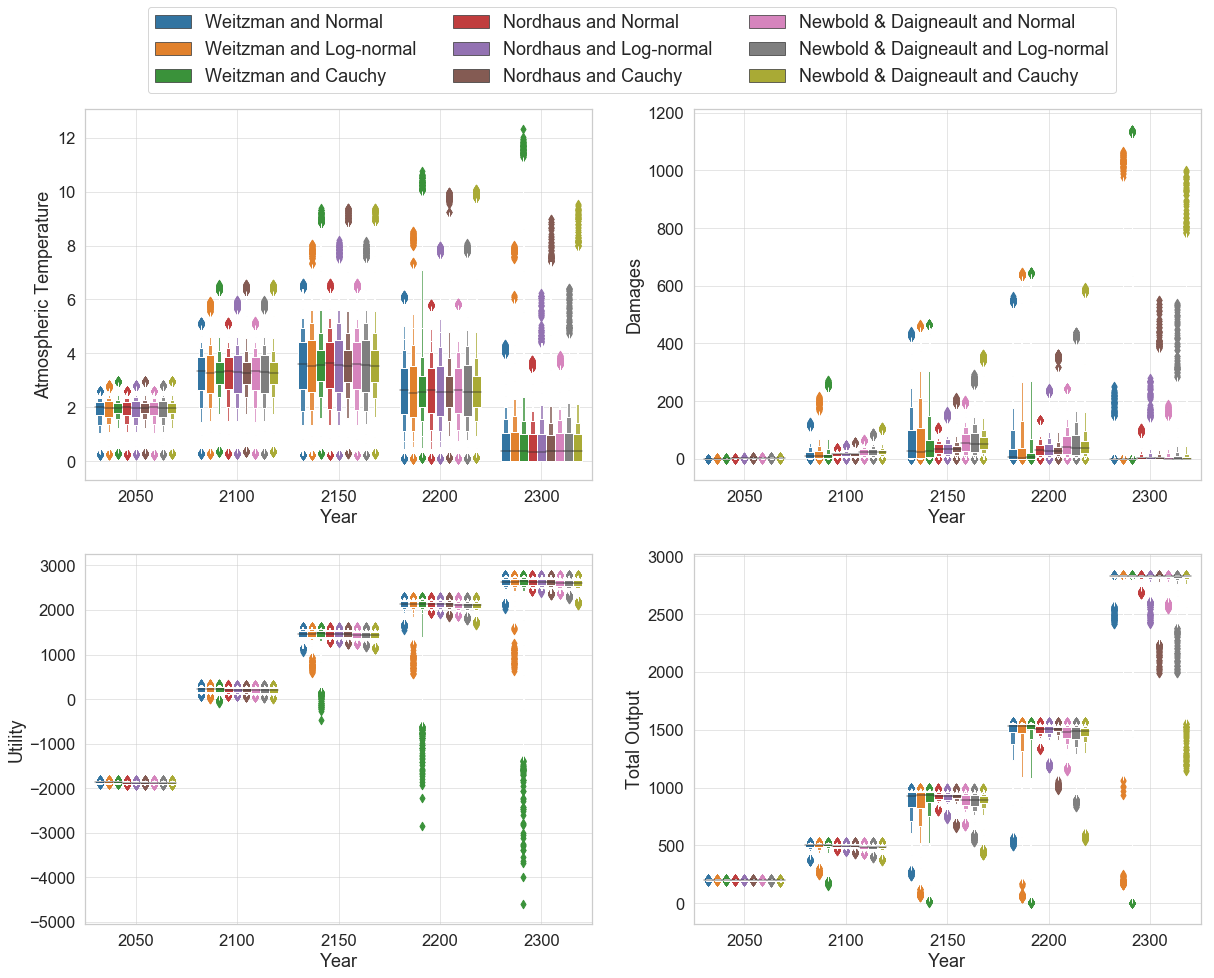

In [151]:
sns.set(style = "whitegrid", palette=sns.set_palette("tab10"), font_scale=1.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
for i in range (2):
    for j in range (2):
        box_damageDF = pd.concat([resDF.iloc[:,19+(2*i+j):-1:4],resDF['fdamage_and_t2xco2_dist']], axis=1, join_axes = [resDF.index])
        box_damageDF.columns = ["2050", "2100", "2150", "2200", "2300","fdamage_and_t2xco2_dist"]    
        box_damageDF = box_damageDF.melt(id_vars=['fdamage_and_t2xco2_dist'], var_name="Year" , value_name=outDF.columns.values[(2*i+j)][:-5])
        box_damageDF = box_damageDF.sort_values([box_damageDF.columns[0]], ascending=False)
        distbox = sns.boxenplot(x="Year", y=outDF.columns.values[(2*i+j)][:-5], data=box_damageDF, hue="fdamage_and_t2xco2_dist", ax=axes[i,j])
        distbox.axes.grid(alpha=0.5)
        distbox.legend().remove()
handles, labels = distbox.get_legend_handles_labels()
distbox.legend(handles[:], labels, bbox_to_anchor=[0.85, 2.5], ncol = 3, fontsize=18)
fig.savefig('boxenplot_dist_fdamage_nordhaus_opt_policy_V4.png', bbox_inches = "tight")

In [152]:
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(100,80))
# for i in range(5):
#     for j in range (4):
#         for k in range(len(np.unique(resDF[resDF.columns[-1]]))):
#             sns.distplot(resDF[resDF[resDF.columns[-1]] == np.unique(resDF[resDF.columns[-1]])[k]][outDF.columns[4:][4*i+j]], 
#                          label = np.unique(resDF[resDF.columns[-1]])[k],
#                          ax = axes[i,j])
#             axes[i][j].legend()

### Describe the statistical results of the model outcome

In [153]:
# for i,j in enumerate(np.unique(resDF[resDF.columns[-1]])):
#     print(i,j)


In [154]:
# res_descDF = resDF.iloc[:,19:].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [155]:
# np.unique(resDF[resDF.columns[-1]])

In [156]:
# weitz_desc_DF = resDF[resDF["fdamage"] == "weitzman"].iloc[:,19:].describe(percentiles = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975])

# colmn_weitz = []
# for _ in weitz_desc_DF.columns.values:
#     colmn_weitz.append(_+' Weitzman')

# weitz_desc_DF.columns = colmn_weitz

In [157]:
# res_descDF

In [158]:
res_descDF = pd.DataFrame([])
for j in (np.unique(resDF[resDF.columns[-1]])):
    descDF = resDF[resDF['fdamage_and_t2xco2_dist'] == j].iloc[:,19:-1].describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]) 
    column_res = []
    for _ in descDF.columns.values:
        column_res.append(_ +"_"+ j)
    descDF.columns = column_res
    res_descDF = res_descDF.append(descDF.T)

res_descDF = res_descDF.T.sort_index(axis=1)

In [160]:
splitDF = np.split(res_descDF, [45,90,135], axis=1)

In [161]:
sheet_name = []
for i in range(4):
    sheet_name.append(str(dice_sm.outcomes[i])[15:-7])
sheet_name.sort()

In [162]:
with pd.ExcelWriter("statistical_description_dist_fdamage_VAR.xlsx") as writer:
    for i in range(4):
        splitDF[i].to_excel(writer, sheet_name=sheet_name[i])